# Comparison of Clustering Methods

This project compares three clustering algorithms — **k-means**, **hierarchical**, and **spectral** — across three datasets with different structures:

| Dataset | Source | Characteristics |
|---------|--------|----------------|
| `iris` | [Built-in R dataset](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/iris.html)  | 3 types of iris flowers, convex clusters, versicolor and virginica classes linearly inseparable, 150 observations, 4 numeric features, 3 balanced target classes. |
| `mtcars` | [Built-in R dataset](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/mtcars.html) | 32 different cars with their paremeters. 32 observations, 9 numeric features (mix of continuous and discrete), 2 nominal. Values of different magnitudes. No predefined target classes. |
| `circles3` | [clusterSim package](https://cran.r-project.org/web/packages/clusterSim/clusterSim.pdf#Rfn.shapes.circles3.1) | 250 synthetic points for each out of 3 2D concentric circles, non-convex clusters, linearly inseperable, connectivity based clusters. Each circle is a target class |

## Environment Preparation

In [1]:
if (!require("pacman")) install.packages("pacman")
library(pacman)

pacman::p_load(Amelia, corrplot, Hmisc, ggplot2, ggfortify, ggforce, clusterSim, kernlab, dplyr, factoextra, clue)

set.seed(111)

Loading required package: pacman



Clustering methods don't classify according to the data classes, so confusion matrices may not contain the number of correctly classified data on the diagonal. To calculate accuracy out of the confusion matrix in this situation the LSAP algorithm can be used.

In [2]:
calculate_accuracy <- function(true_labels, cluster_labels) {
  conf_mat <- table(true_labels, cluster_labels)
  
  # Finds the optimal assignment between rows and columns
  # solve_LSAP returns a vector of column indices for each row
  assignment <- solve_LSAP(conf_mat, maximum = TRUE)
  
  # 3. Calculate Accuracy
  # Sum the matched cells / Total instances
  matched_sum <- sum(conf_mat[cbind(seq_along(assignment), assignment)])
  
  return(matched_sum / sum(conf_mat))
}

## Exploratory Data Analysis (EDA)

Before clustering, each dataset is inspected for data types, value ranges, missing values, and feature correlations. PCA visualizations are made.

### Iris Dataset

![iris](images/iris.png)

*Source: https://codesignal.com/learn/courses/intro-to-unsupervised-machine-learning/lessons/exploring-and-visualizing-the-iris-dataset*

In [3]:
# Data types are correct
str(iris)

'data.frame':	150 obs. of  5 variables:
 $ Sepal.Length: num  5.1 4.9 4.7 4.6 5 5.4 4.6 5 4.4 4.9 ...
 $ Sepal.Width : num  3.5 3 3.2 3.1 3.6 3.9 3.4 3.4 2.9 3.1 ...
 $ Petal.Length: num  1.4 1.4 1.3 1.5 1.4 1.7 1.4 1.5 1.4 1.5 ...
 $ Petal.Width : num  0.2 0.2 0.2 0.2 0.2 0.4 0.3 0.2 0.2 0.1 ...
 $ Species     : Factor w/ 3 levels "setosa","versicolor",..: 1 1 1 1 1 1 1 1 1 1 ...


In [4]:
# Species are evenly distributed
# Values of each feature are of the same magnitude, variance is comparable
summary(iris)

  Sepal.Length    Sepal.Width     Petal.Length    Petal.Width   
 Min.   :4.300   Min.   :2.000   Min.   :1.000   Min.   :0.100  
 1st Qu.:5.100   1st Qu.:2.800   1st Qu.:1.600   1st Qu.:0.300  
 Median :5.800   Median :3.000   Median :4.350   Median :1.300  
 Mean   :5.843   Mean   :3.057   Mean   :3.758   Mean   :1.199  
 3rd Qu.:6.400   3rd Qu.:3.300   3rd Qu.:5.100   3rd Qu.:1.800  
 Max.   :7.900   Max.   :4.400   Max.   :6.900   Max.   :2.500  
       Species  
 setosa    :50  
 versicolor:50  
 virginica :50  
                
                
                

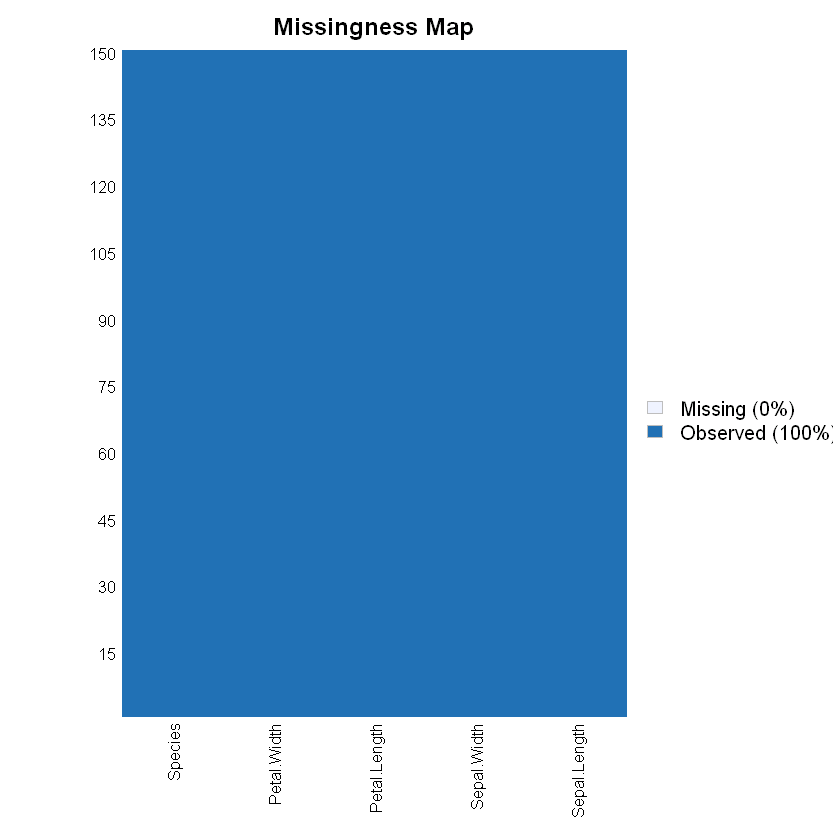

In [5]:
# No missing values
missmap(iris)

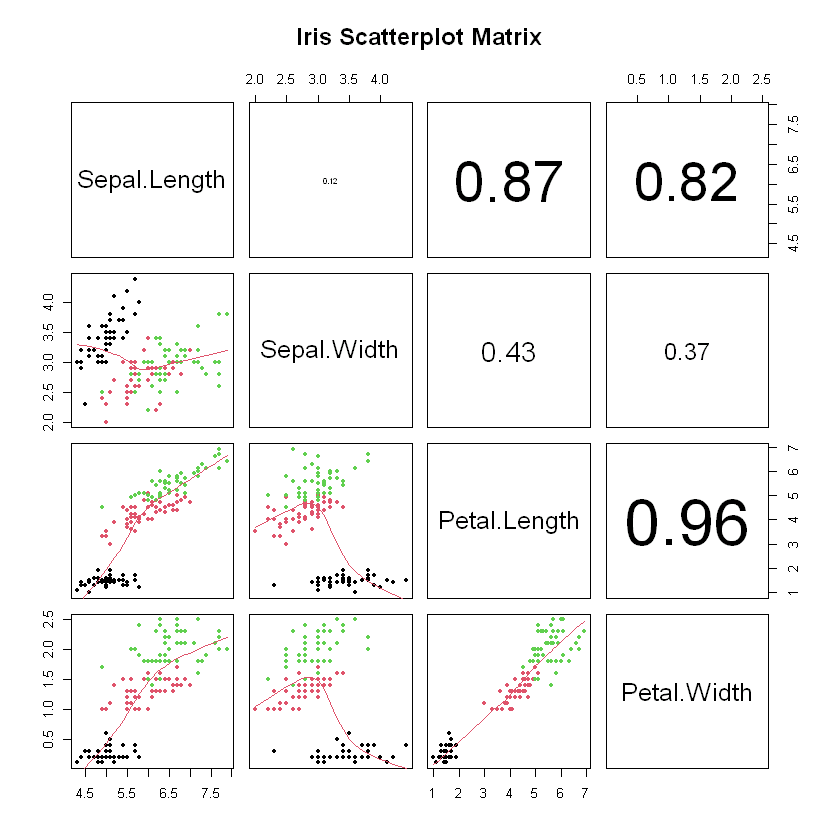

In [6]:
panel.cor <- function(x, y, digits = 2, prefix = "", cex.cor, ...) {
  usr <- par("usr")
  on.exit(par(usr = usr))
  par(usr = c(0, 1, 0, 1))
  r <- abs(cor(x, y))
  txt <- format(c(r, 0.123456789), digits = digits)[1]
  txt <- paste(prefix, txt, sep = "")
  if (missing(cex.cor)) cex.cor <- 0.8 / strwidth(txt)
  text(0.5, 0.5, txt, cex = cex.cor * r)
}

pairs(~Sepal.Length + Sepal.Width + Petal.Length + Petal.Width,
      data = iris,
      lower.panel = panel.smooth, upper.panel = panel.cor,
      pch = 20, main = "Iris Scatterplot Matrix", col = iris$Species)

In [7]:
# Remove the Species column
data_iris <- iris[1:4]

# Z-score normalization (mean=0, sd=1) of each feature
data_iris_z <- as.data.frame(lapply(data_iris, scale))

In [8]:
pca_iris <- prcomp(data_iris_z, scale. = FALSE)
summary(pca_iris)$importance[, 1:2] # PCA visualizations make sense, because PC1 + PC2 contain 95% of variance

,PC1,PC2
Standard deviation,1.708361,0.9560494
Proportion of Variance,0.729620,0.2285100
Cumulative Proportion,0.729620,0.9581300


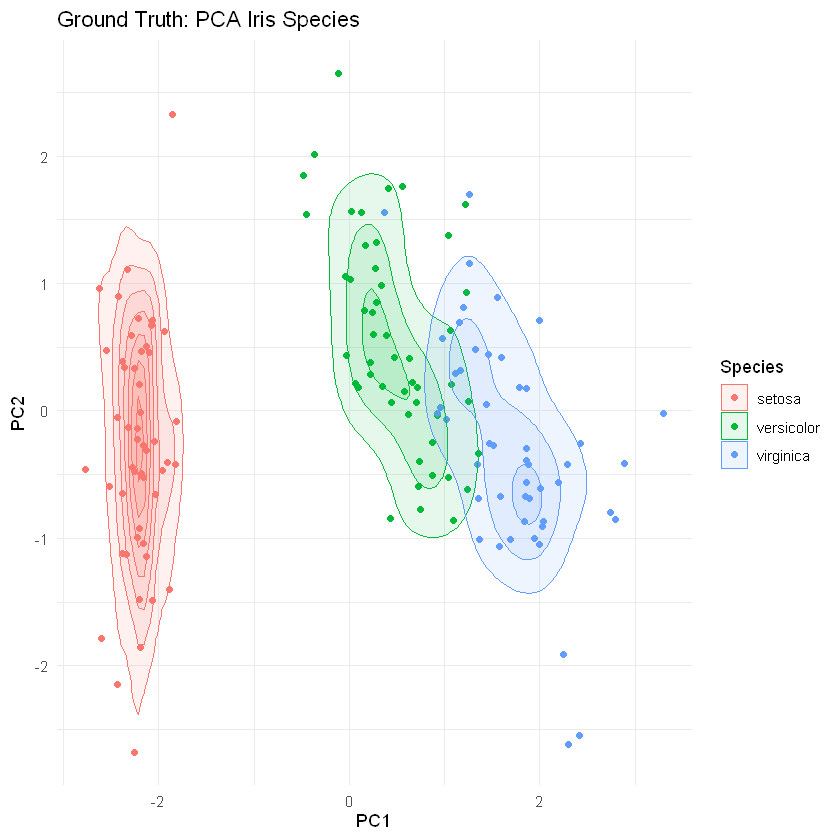

In [9]:
pca_iris_df <- as.data.frame(pca_iris$x)
pca_iris_gt <- pca_iris_df
pca_iris_gt$Species <- iris$Species

ggplot(pca_iris_gt, aes(x = PC1, y = PC2, color = Species)) +
  geom_point() + 
  stat_density_2d(aes(fill = Species), geom = "polygon", alpha = 0.1, bins = 8) +
  theme_minimal() +
  labs(title = "Ground Truth: PCA Iris Species")

### mtcars Dataset

In [10]:
# Most features are numerical continuous and discrete. Two nominal ones - vs and am.
str(mtcars)

'data.frame':	32 obs. of  11 variables:
 $ mpg : num  21 21 22.8 21.4 18.7 18.1 14.3 24.4 22.8 19.2 ...
 $ cyl : num  6 6 4 6 8 6 8 4 4 6 ...
 $ disp: num  160 160 108 258 360 ...
 $ hp  : num  110 110 93 110 175 105 245 62 95 123 ...
 $ drat: num  3.9 3.9 3.85 3.08 3.15 2.76 3.21 3.69 3.92 3.92 ...
 $ wt  : num  2.62 2.88 2.32 3.21 3.44 ...
 $ qsec: num  16.5 17 18.6 19.4 17 ...
 $ vs  : num  0 0 1 1 0 1 0 1 1 1 ...
 $ am  : num  1 1 1 0 0 0 0 0 0 0 ...
 $ gear: num  4 4 4 3 3 3 3 4 4 4 ...
 $ carb: num  4 4 1 1 2 1 4 2 2 4 ...


In [11]:
# Summary statistics
summary(mtcars)

      mpg             cyl             disp             hp       
 Min.   :10.40   Min.   :4.000   Min.   : 71.1   Min.   : 52.0  
 1st Qu.:15.43   1st Qu.:4.000   1st Qu.:120.8   1st Qu.: 96.5  
 Median :19.20   Median :6.000   Median :196.3   Median :123.0  
 Mean   :20.09   Mean   :6.188   Mean   :230.7   Mean   :146.7  
 3rd Qu.:22.80   3rd Qu.:8.000   3rd Qu.:326.0   3rd Qu.:180.0  
 Max.   :33.90   Max.   :8.000   Max.   :472.0   Max.   :335.0  
      drat             wt             qsec             vs        
 Min.   :2.760   Min.   :1.513   Min.   :14.50   Min.   :0.0000  
 1st Qu.:3.080   1st Qu.:2.581   1st Qu.:16.89   1st Qu.:0.0000  
 Median :3.695   Median :3.325   Median :17.71   Median :0.0000  
 Mean   :3.597   Mean   :3.217   Mean   :17.85   Mean   :0.4375  
 3rd Qu.:3.920   3rd Qu.:3.610   3rd Qu.:18.90   3rd Qu.:1.0000  
 Max.   :4.930   Max.   :5.424   Max.   :22.90   Max.   :1.0000  
       am              gear            carb      
 Min.   :0.0000   Min.   :3.000  

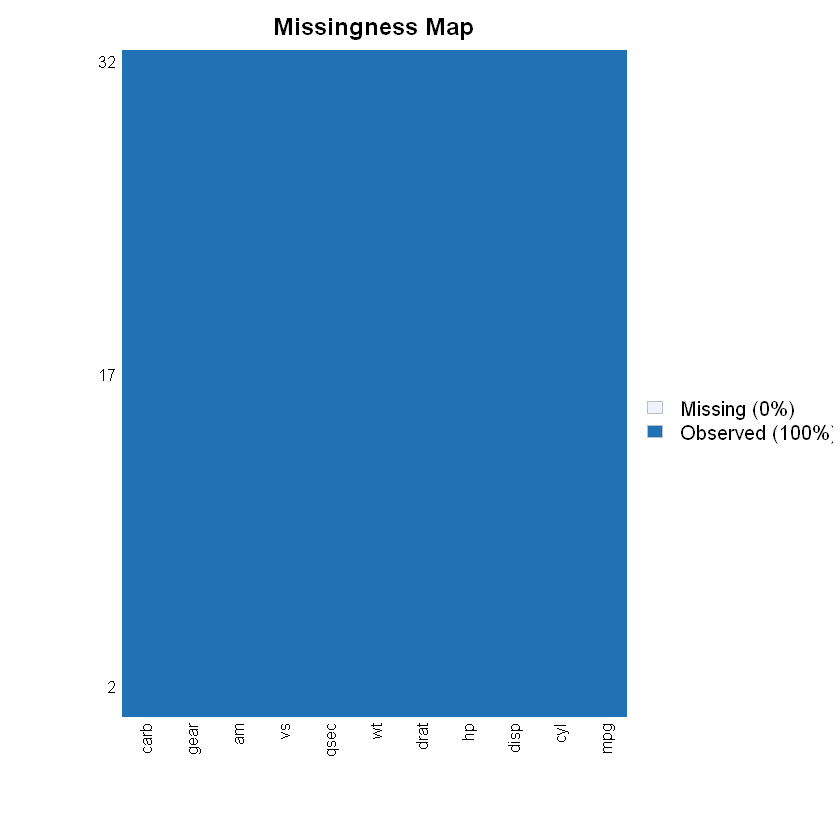

In [12]:
# Confirm there are no missing values
missmap(mtcars)

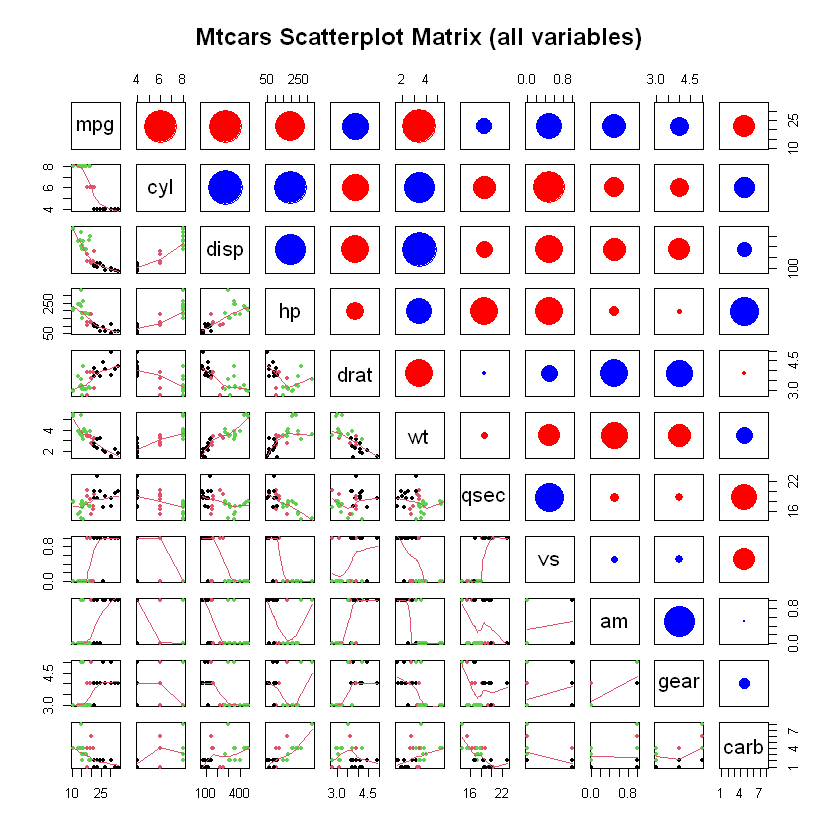

In [13]:
panel.cor.circle <- function(x, y, ...) {
  usr <- par("usr")
  on.exit(par(usr = usr))
  par(usr = c(0, 1, 0, 1))
  r <- cor(x, y)
  if (is.na(r)) r <- 0
  radius <- 0.4 * abs(r)
  if (radius < 0.02) radius <- 0.02
  col <- if (r >= 0) "blue" else "red"
  symbols(0.5, 0.5, circles = radius, inches = FALSE, add = TRUE, fg = col, bg = col)
}

pairs(mtcars,
      lower.panel = panel.smooth,
      upper.panel = panel.cor.circle,
      pch = 20,
      main = "Mtcars Scatterplot Matrix (all variables)",
      col = factor(mtcars$cyl))

In [14]:
# remove nominal variables
drop_cols <- c("vs", "am")

data_mtcars <- mtcars[, !names(mtcars) %in% drop_cols]

data_mtcars_z <- scale(data_mtcars)

In [15]:
pca_mtcars <- prcomp(data_mtcars_z, scale. = FALSE)
summary(pca_mtcars)$importance[, 1:2] # PCA visualizations make sense, because PC1 + PC2 contains 86% of variance

,PC1,PC2
Standard deviation,2.378222,1.442948
Proportion of Variance,0.628440,0.231340
Cumulative Proportion,0.628440,0.859780


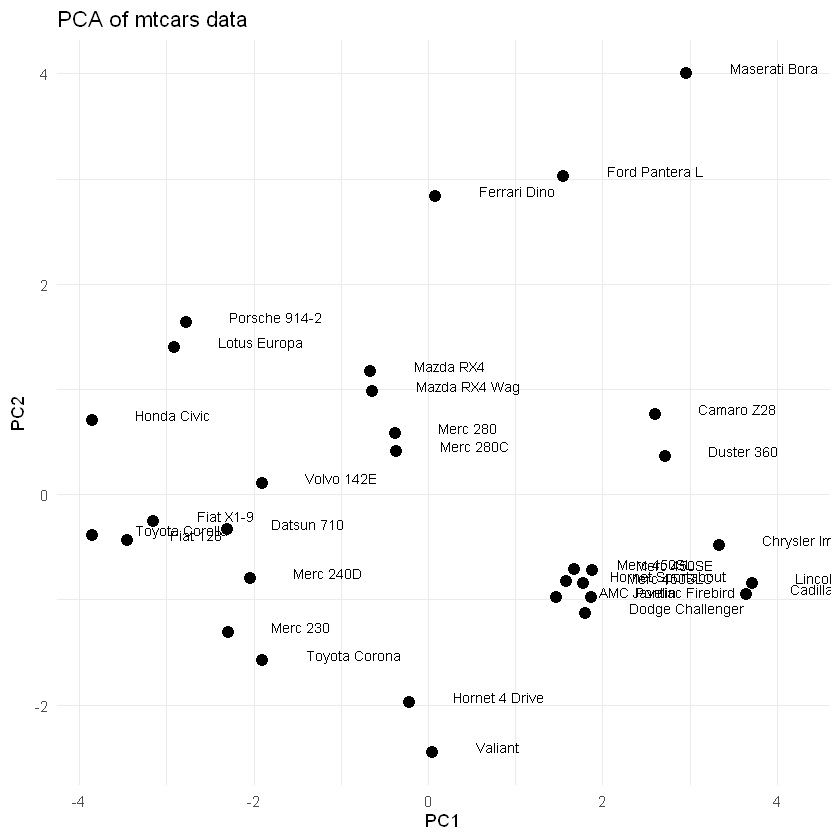

In [16]:
pca_mtcars_df <- as.data.frame(pca_mtcars$x)

ggplot(pca_mtcars_df, aes(x = PC1, y = PC2)) +
  geom_point(size = 3) +
  geom_text(aes(label = rownames(pca_mtcars_df)), 
            hjust = 0, vjust = 0, size = 3, nudge_x = 0.5) +
  theme_minimal() +
  labs(title = "PCA of mtcars data")

### Circles3 Dataset

The `circles3` dataset from `clusterSim` generates three concentric circles. It is non-convex, which means that k-means and hierarchical methods should struggle.

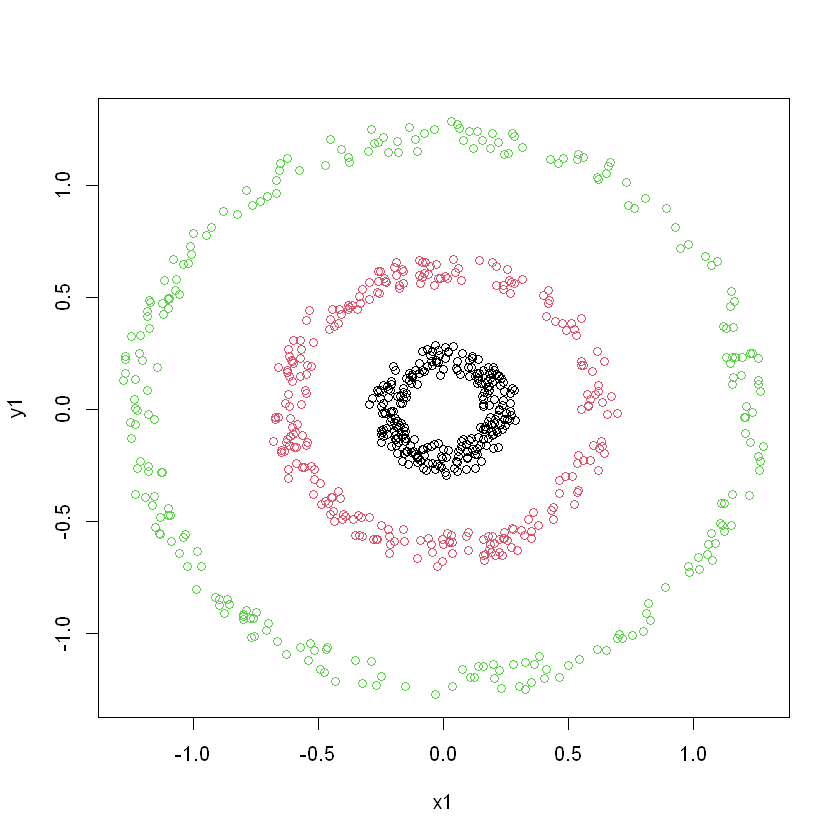

In [17]:
# Generate 250 points for each circle. They share the same center.
circles3 <- shapes.circles3(numObjects = 250)

plot(circles3$data, col = circles3$clusters)

## K-Means Algorithm

K-means partitions data into *k* clusters by iteratively assigning points to the nearest centroid and updating centroids. It assumes convex, roughly spherical clusters of similar size. Results depend on the choice of *k* and the initial centroids.

### iris Dataset

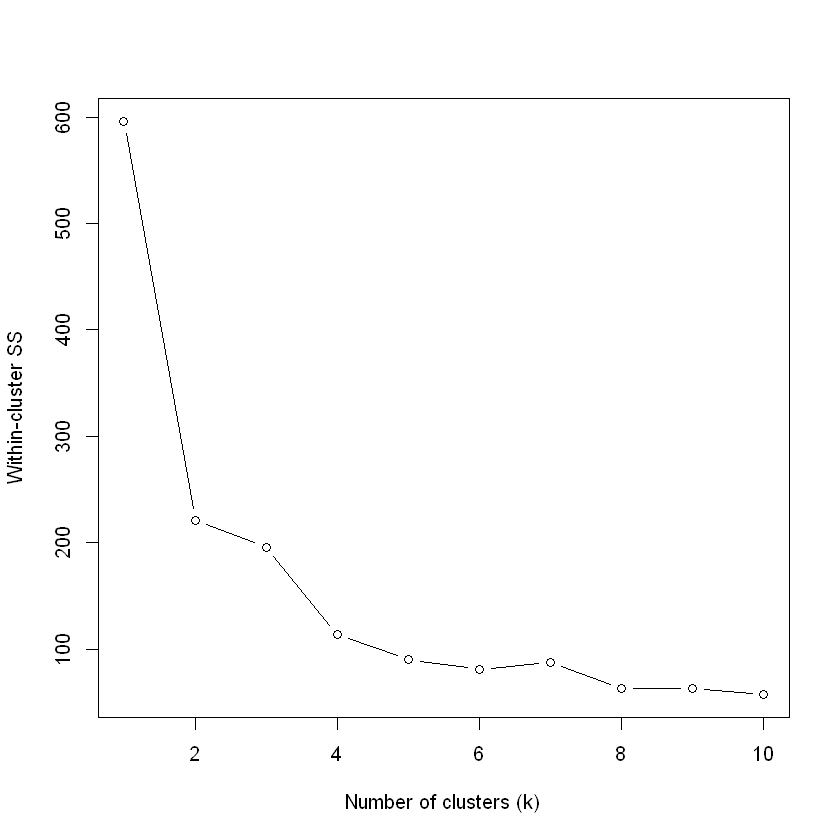

In [18]:
# Elbow rule
wss <- (nrow(data_iris_z) - 1) * sum(apply(data_iris_z, 2, var))  # WSS for k=1

for (i in 2:10) {
  wss[i] <- sum(kmeans(data_iris_z, centers = i)$withinss)
}

plot(1:10, wss, type = "b", xlab = "Number of clusters (k)", ylab = "Within-cluster SS")

k = 3 from the a priori knowledge.

In [19]:
iris_clusters_k_means <- kmeans(data_iris_z, 3)

# Confusion matrix
table(iris$Species, iris_clusters_k_means$cluster)

            
              1  2  3
  setosa      0 50  0
  versicolor 11  0 39
  virginica  36  0 14

In [20]:
cat("Accuracy: ", calculate_accuracy(iris$Species, iris_clusters_k_means$cluster))

Accuracy:  0.8333333

Mismatch is visible only between versicolor and virginica (which was expected).

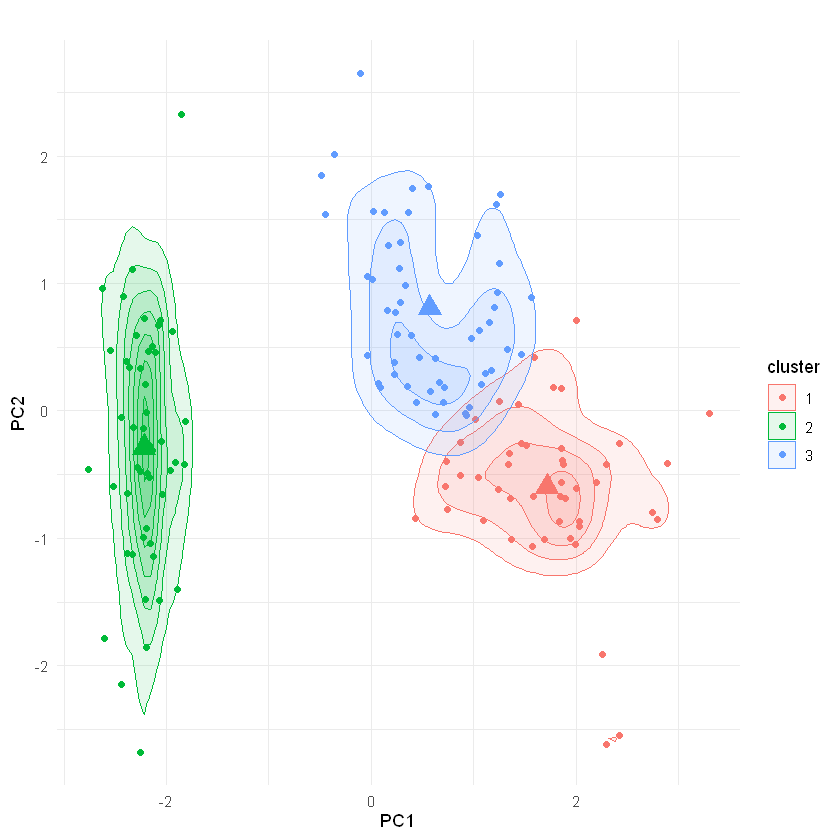

In [21]:
centers_iris <- iris_clusters_k_means$centers
centers_iris_pca <- as.data.frame(centers_iris %*% pca_iris$rotation)
centers_iris_pca$cluster <- as.factor(1:3)

# PCA scatter plot
pca_iris_k_means <- pca_iris_df
pca_iris_k_means$cluster <- as.factor(iris_clusters_k_means$cluster)

ggplot(pca_iris_k_means, aes(x = PC1, y = PC2, color = cluster)) +
  geom_point() +
  stat_density_2d(aes(fill = cluster), geom = "polygon", alpha = 0.1, bins = 8) +
  geom_point(data = centers_iris_pca, aes(x = PC1, y = PC2, color = cluster), 
             size = 5, shape = 17, show.legend = FALSE) +
  theme_minimal() +
  ggtitle("")

### mtcars Dataset

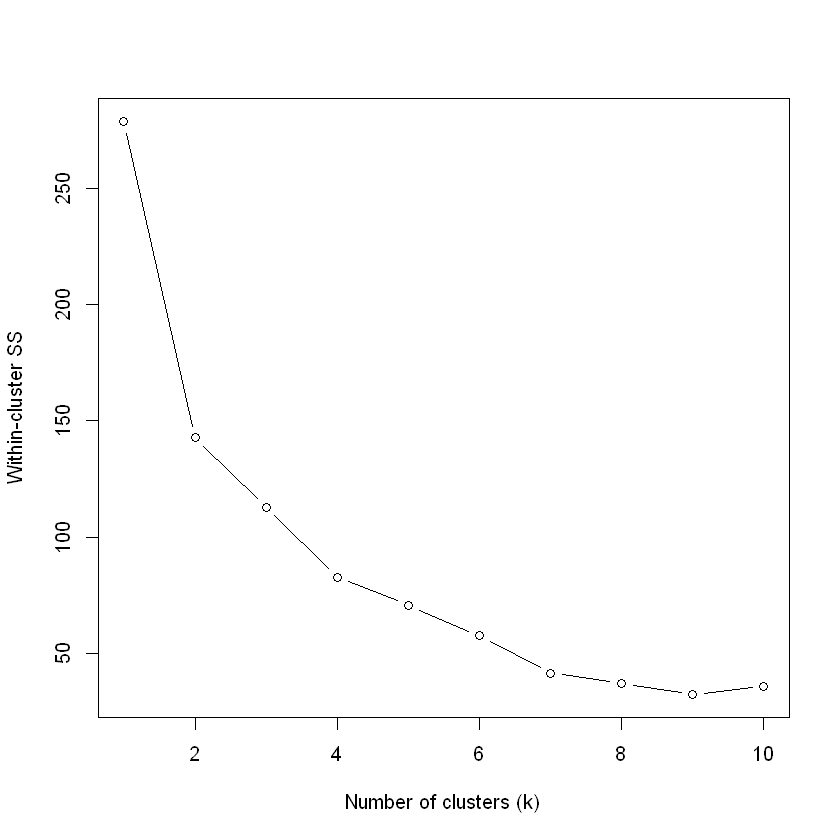

In [22]:
# Elbow method for mtcars
wss <- (nrow(data_mtcars_z) - 1) * sum(apply(data_mtcars_z, 2, var))

for (i in 2:10) {
  wss[i] <- sum(kmeans(data_mtcars_z, centers = i)$withinss)
}

# The elbow is less pronounced here — mtcars has no strongly separated groups
plot(1:10, wss, type = "b", xlab = "Number of clusters (k)", ylab = "Within-cluster SS")

Choose k=4 based on the elbow plot

In [23]:
mtcars_clusters_k_means <- kmeans(data_mtcars_z, centers = 4)

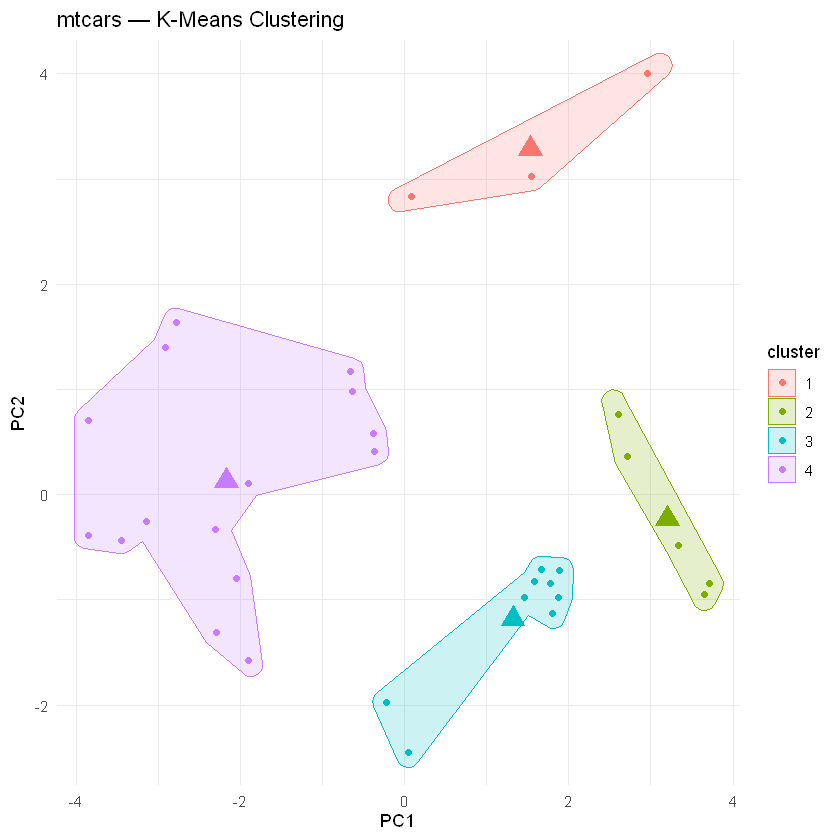

In [24]:
pca_mtcars_k_means <- pca_mtcars_df
pca_mtcars_k_means$cluster <- as.factor(mtcars_clusters_k_means$cluster)

centers_mtcars <- mtcars_clusters_k_means$centers
centers_mtcars_pca <- as.data.frame(centers_mtcars %*% pca_mtcars$rotation)
centers_mtcars_pca$cluster <- as.factor(1:4)

# PCA scatter plot
ggplot(pca_mtcars_k_means, aes(x = PC1, y = PC2, color = cluster)) +
  geom_mark_hull(aes(fill = cluster), concavity = 2, expand = 0.02, alpha = 0.2) +
  geom_point() +
  geom_point(data = centers_mtcars_pca, aes(x = PC1, y = PC2, color = cluster), 
             size = 5, shape = 17, show.legend = FALSE) +
  theme_minimal() +
  ggtitle("mtcars — K-Means Clustering")

### circles3 Dataset

K-means assigns points to the nearest centroid using Euclidean distance. Because the three circles have the same center, centroids cannot separate them — the algorithm will slice the data radially instead of following the circular boundaries.

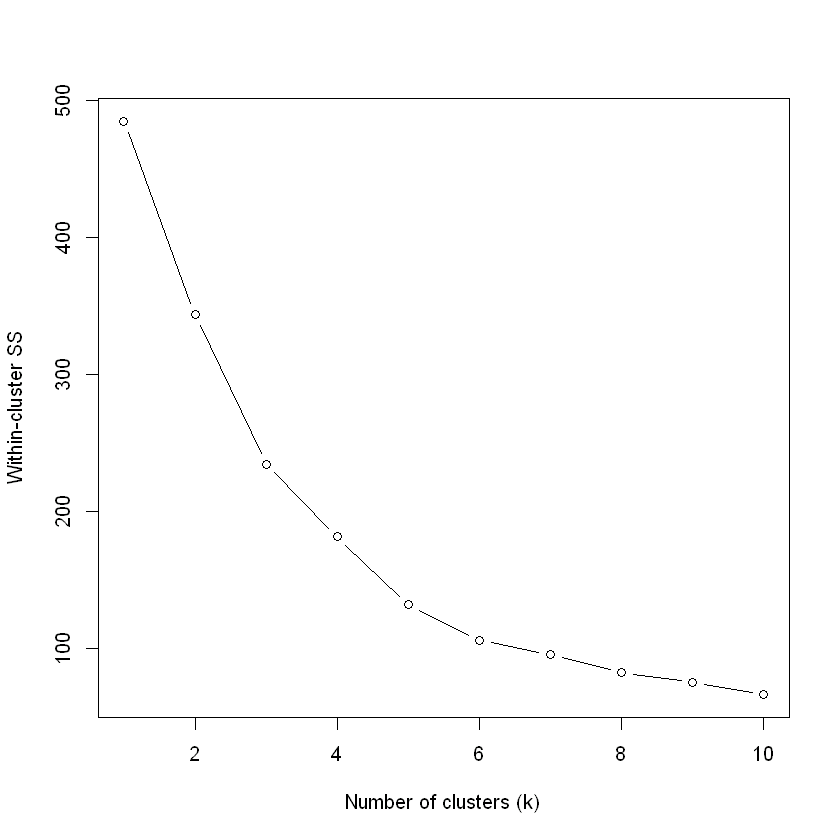

In [25]:
# Elbow rule
wss <- (nrow(circles3$data) - 1) * sum(apply(circles3$data, 2, var))

for (i in 2:10) {
  wss[i] <- sum(kmeans(circles3$data, centers = i)$withinss)
}

plot(1:10, wss, type = "b", xlab = "Number of clusters (k)", ylab = "Within-cluster SS")

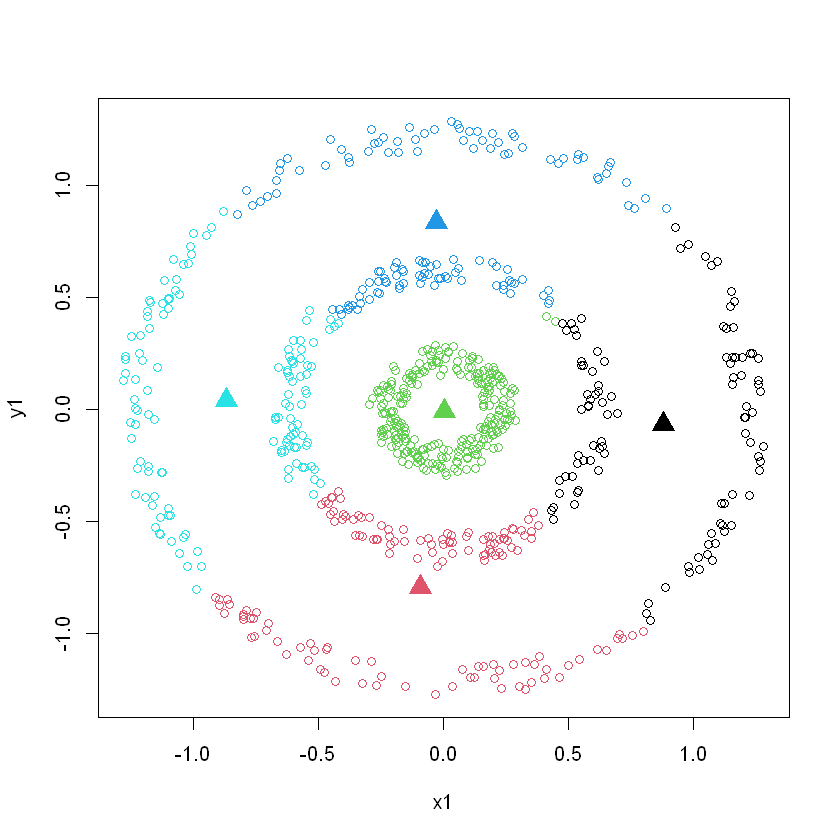

In [26]:
# Using k=5 instead of the a priori k=3.
# with this change, the algorithm is able to identify the innermost circle

circles3_clusters_k_means <- kmeans(circles3$data, 5)
plot(circles3$data, col = circles3_clusters_k_means$cluster)
points(circles3_clusters_k_means$centers, col = 1:5, pch = 17, cex = 2)

In [27]:
# Confusion matrix
table(circles3$clusters, circles3_clusters_k_means$cluster)

   
      1   2   3   4   5
  1   0   0 250   0   0
  2  44  78   2  64  62
  3  57  64   0  61  68

In [28]:
cat("Accuracy: ", calculate_accuracy(circles3$clusters, circles3_clusters_k_means$cluster))

Accuracy:  0.528

## Hierarchical Clustering

Hierarchical clustering builds a tree of merges from individual points up to a single cluster. 

The `cluster.Sim()` function from `clusterSim` automates the search over multiple linkage methods and distance measures, selecting the combination that optimizes a given validity index.

**Methods tested** (`m1`–`m4`, `m5`–`m8`): single, complete, average, McQuitty, Ward's, centroid, and median linkage.

**Distance measures tested**: Manhattan, Euclidean, Chebychev (max), squared Euclidean, GDM1

**Target metric** (chosen empirically): iris - Calinski & Harabasz (G1), mtcars and circles3 - Baker & Hubert (G2)

The directory on more details about this method can be found by running:

`file_path <- system.file("pdf", "clusterSim_details.pdf", package = "clusterSim")`

### iris Dataset

In [29]:
# Parameters: data, simulation_path=7 (without normalizing data), min_k=1, max_k=4, target_metric="G1"
sim_opt_iris <- cluster.Sim(data_iris_z, 7, 3, 3, "G1",
                            outputCsv = "hierarchical_iris",
                            methods = c("m1", "m2", "m3", "m4", "m6", "m7", "m8"))

cat("Best hyperparameters:\n","distance: ", sim_opt_iris$distance,
    "\nmethod: ", sim_opt_iris$method,
    "\nnr of classes: ", sim_opt_iris$classes)

Best hyperparameters:
 distance:  GDM1 
method:  mcquitty 
nr of classes:  3

In [30]:
# Confusion matrix
table(iris$Species, sim_opt_iris$optClustering)

            
              1  2  3
  setosa     50  0  0
  versicolor  0  5 45
  virginica   0 33 17

In [31]:
cat("Accuracy: ", calculate_accuracy(iris$Species, sim_opt_iris$optClustering))

Accuracy:  0.8533333

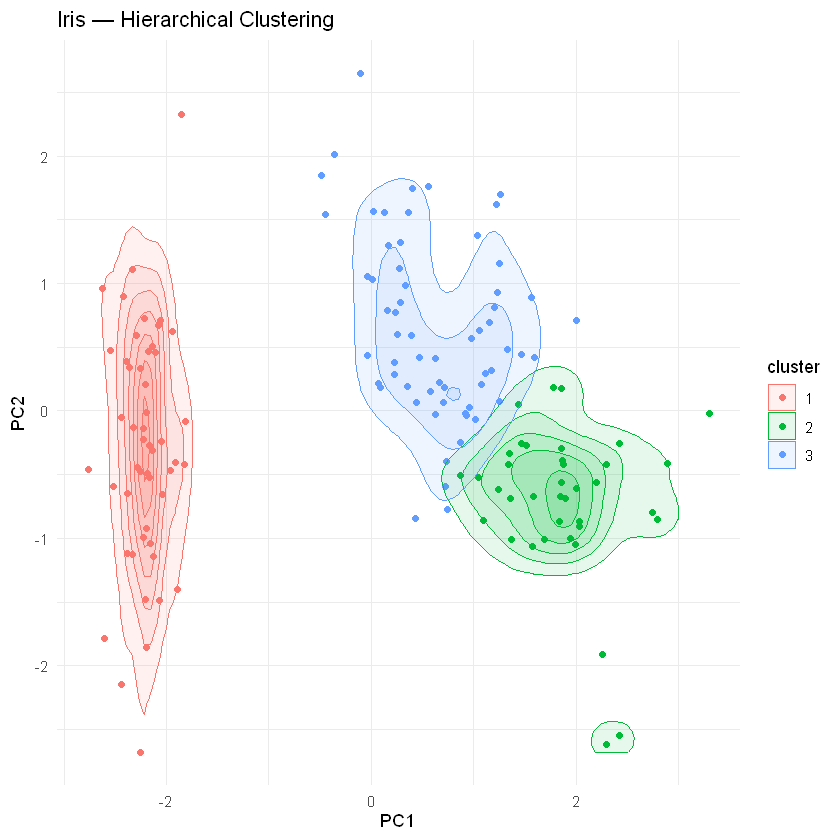

In [32]:
# PCA projection with hierarchical cluster labels
pca_iris_hierarchical <- pca_iris_df
pca_iris_hierarchical$cluster <- as.factor(sim_opt_iris$optClustering)

# PCA scatter plot of hierarchical clustering results on iris
ggplot(pca_iris_hierarchical, aes(x = PC1, y = PC2, color = cluster)) +
  geom_point() +
  #stat_ellipse(aes(group = cluster), type = "norm", level = 0.95) +
  stat_density_2d(aes(fill = cluster), geom = "polygon", alpha = 0.1, bins = 8) +
  theme_minimal() +
  ggtitle("Iris — Hierarchical Clustering")

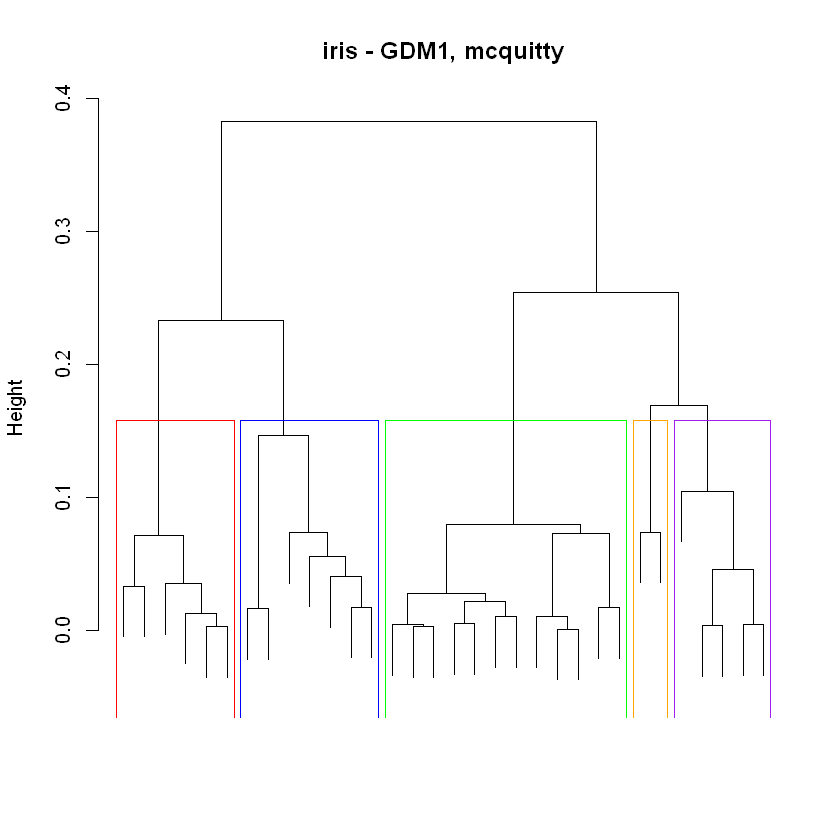

In [33]:
# Plot the dendrogram with clusters
dist_matrix <- dist.GDM(data_mtcars_z, method = "GDM1")

hc_result <- hclust(dist_matrix, method = "mcquitty")

plot(hc_result, main = "iris - GDM1, mcquitty", 
     xlab = "", sub = "", labels = FALSE)

rect.hclust(hc_result, k = 5, border = c("red", "blue", "green", "orange", "purple"))

### mtcars Dataset

In [34]:
sim_opt_mtcars <- cluster.Sim(data_mtcars_z, 7, 2, 5, "G2",
                              outputCsv = "hierarchical_mtcars",
                              methods = c("m1", "m2", "m3", "m4", "m6", "m7", "m8"))

cat("Best hyperparameters:\n","distance: ", sim_opt_mtcars$distance,
    "\nmethod: ", sim_opt_mtcars$method,
    "\nnr of classes: ", sim_opt_mtcars$classes)

[1] "Calculations of G2 internal cluster quality index may be sligthly slow. Iteration step informations will be diplayed"
Best hyperparameters:
 distance:  GDM1 
method:  single 
nr of classes:  5

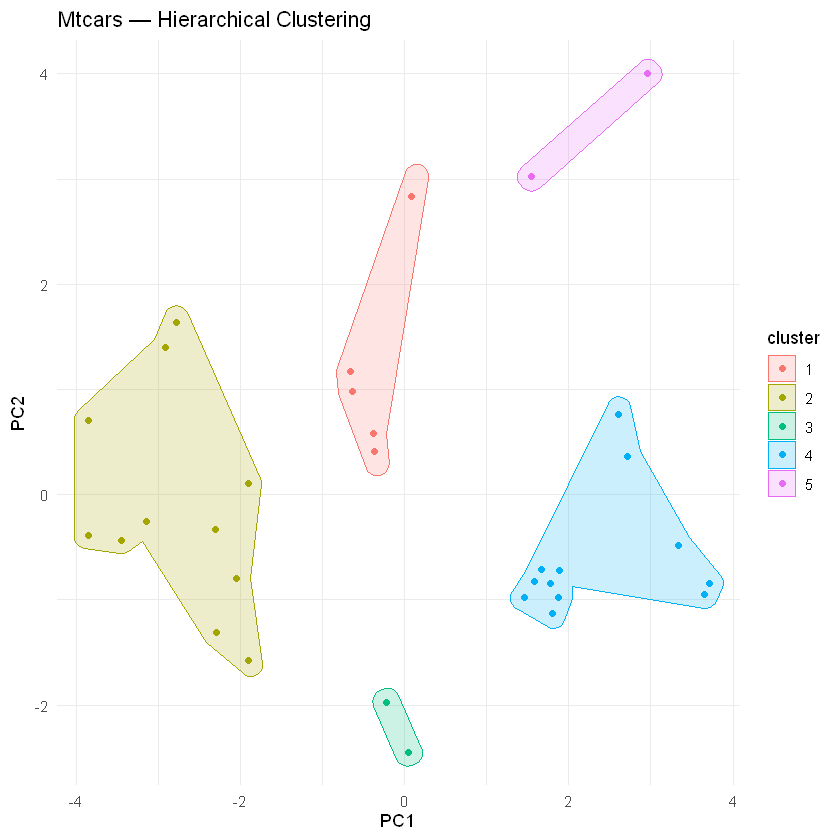

In [35]:
# PCA projection with hierarchical cluster labels
pca_mtcars_hierarchical <- pca_mtcars_df
pca_mtcars_hierarchical$cluster <- as.factor(sim_opt_mtcars$optClustering)

# PCA scatter plot
ggplot(pca_mtcars_hierarchical, aes(x = PC1, y = PC2, color = cluster)) +
  geom_mark_hull(aes(fill = cluster), concavity = 2, expand = 0.02, alpha = 0.2) +
  geom_point() +
  theme_minimal() +
  ggtitle("Mtcars — Hierarchical Clustering")

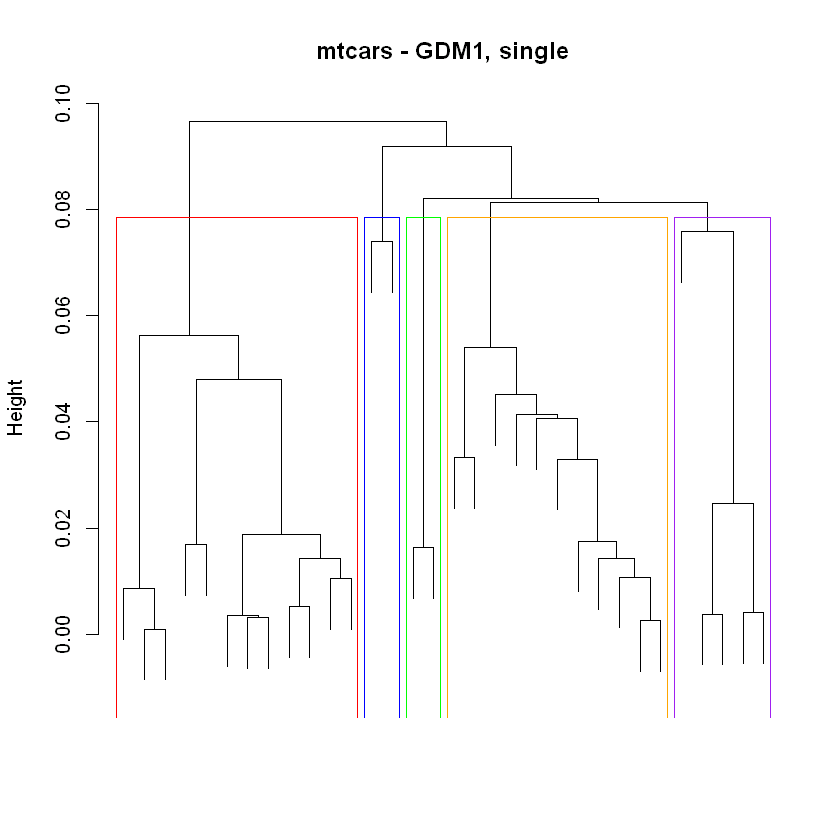

In [36]:
# Plot the dendrogram with clusters

dist_matrix <- dist.GDM(data_mtcars_z, method = "GDM1")

hc_result <- hclust(dist_matrix, method = "single")

plot(hc_result, main = "mtcars - GDM1, single", 
     xlab = "", sub = "", labels = FALSE)

rect.hclust(hc_result, k = 5, border = c("red", "blue", "green", "orange", "purple"))

### circles3 Dataset

In [37]:
sim_opt_circles3 <- cluster.Sim(circles3$data, 7, 3, 3, "G2",
                         outputCsv = "hierarchical_circles3",
                         methods = c("m1", "m2", "m3", "m4", "m6", "m7", "m8"))

cat("Best hyperparameters:\n","distance: ", sim_opt_circles3$distance,
    "\nmethod: ", sim_opt_circles3$method,
    "\nnr of classes: ", sim_opt_circles3$classes)

[1] "Calculations of G2 internal cluster quality index may be sligthly slow. Iteration step informations will be diplayed"
Best hyperparameters:
 distance:  Euclidean 
method:  complete 
nr of classes:  3

In [38]:
# Confusion matrix
table(circles3$clusters, sim_opt_circles3$optClustering)

   
      1   2   3
  1 250   0   0
  2 100  84  66
  3  51  90 109

In [39]:
cat("Accuracy: ", calculate_accuracy(circles3$clusters, sim_opt_circles3$optClustering))

Accuracy:  0.5906667

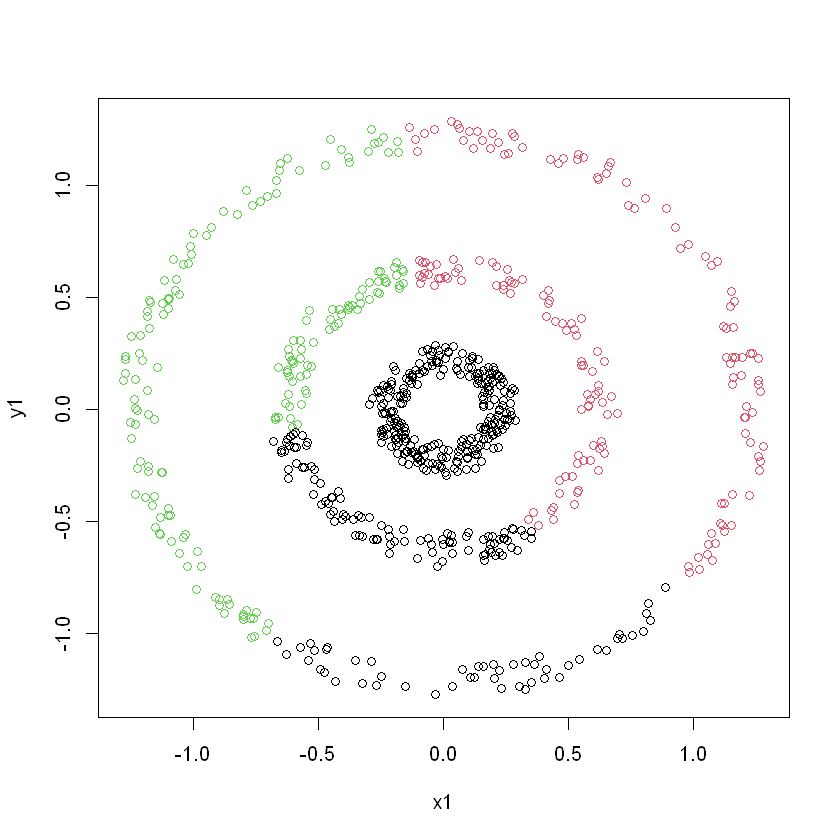

In [40]:
plot(circles3$data, col = sim_opt_circles3$optClustering)

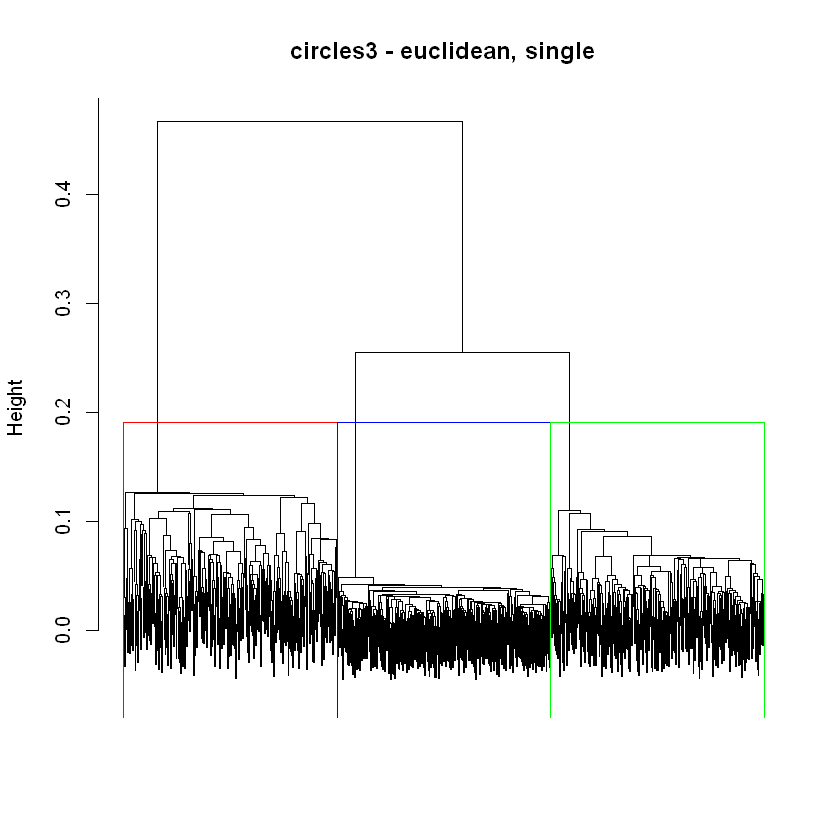

In [41]:
# Plot the dendrogram with clusters

dist_matrix <- dist(circles3$data, method = "euclidean")

hc_result <- hclust(dist_matrix, method = "single")

plot(hc_result, main = "circles3 - euclidean, single", 
     xlab = "", sub = "", labels = FALSE)

rect.hclust(hc_result, k = 3, border = c("red", "blue", "green"))

## Spectral Clustering

Spectral clustering transforms data into a space defined by eigenvectors of a similarity (or Laplacian) matrix, then applies k-means in that space. This allows it to find non-convex clusters that k-means alone cannot detect.

The `specc()` function from `kernlab` uses an RBF (Gaussian) kernel to build the similarity matrix. I conduct kernel badwith optimization.

### iris Dataset

Hyperparameter optimization is neccessary, because defaut parameters for specc() gives poor resuls.

In [42]:
sigma_values <- seq(0.1, 4, by = 0.02)
results <- list()

for(i in seq_along(sigma_values)) {
  sigma <- sigma_values[i]
  spec_iris <- specc(as.matrix(data_iris_z), centers = 3, 
                     kernel = "rbfdot", kpar = list(sigma = sigma))
  
  confusion <- table(iris$Species, spec_iris@.Data)

  accuracy <- calculate_accuracy(iris$Species, spec_iris@.Data)
  
  results[[i]] <- list(
    sigma = sigma,
    confusion = confusion,
    accuracy = accuracy
  )
  
  #cat("\n=== Sigma =", sigma, "| Accuracy =", round(accuracy, 3), "===\n")
  #print(confusion)
}

# Find best sigma
best_idx <- which.max(sapply(results, function(x) x$accuracy))
cat("\nBest sigma:", results[[best_idx]]$sigma, 
    "with accuracy:", round(results[[best_idx]]$accuracy, 3), "\n")


Best sigma: 1.68 with accuracy: 0.86 


Explore impact of sigma hyperparameter on accuracy

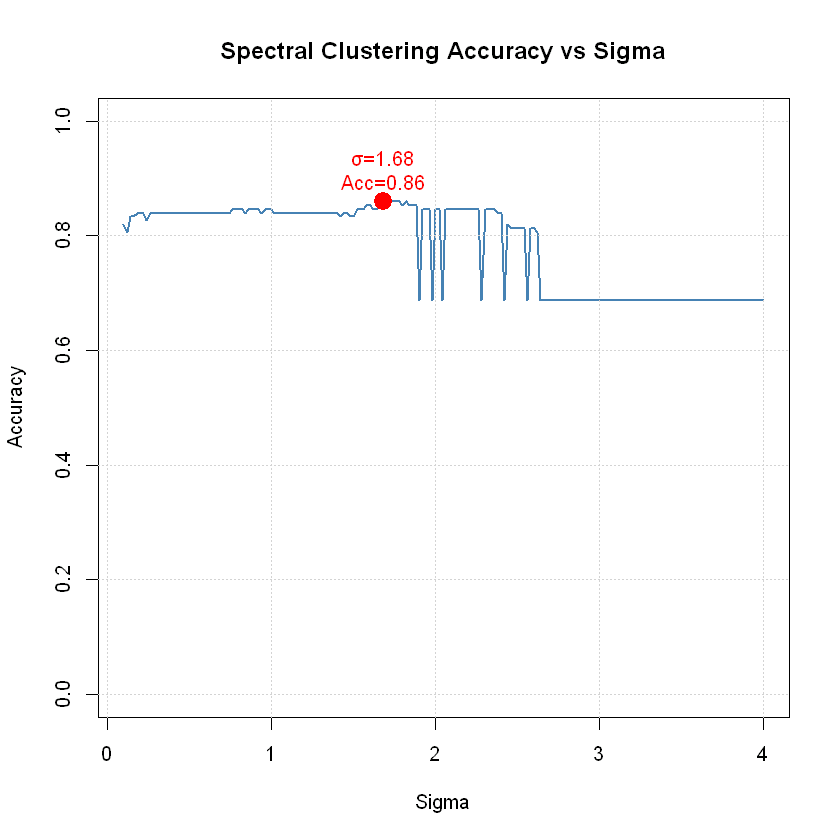

In [43]:
# Line plot: Accuracy vs Sigma
accuracies <- sapply(results, function(x) x$accuracy)
sigma_vals <- sapply(results, function(x) x$sigma)

plot(sigma_vals, accuracies, 
     type = "l", 
     lwd = 2,
     col = "steelblue",
     main = "Spectral Clustering Accuracy vs Sigma",
     xlab = "Sigma",
     ylab = "Accuracy",
     ylim = c(0, 1))
grid()

# Mark the best sigma
best_sigma <- results[[best_idx]]$sigma
best_accuracy <- results[[best_idx]]$accuracy
points(best_sigma, best_accuracy, col = "red", pch = 19, cex = 2)
text(best_sigma, best_accuracy, 
     labels = paste0("σ=", round(best_sigma, 2), "\nAcc=", round(best_accuracy, 3)),
     pos = 3, col = "red")

In [44]:
# Spectral clustering on the z-scored iris data with k=3
spec_iris <- specc(as.matrix(data_iris_z), centers = 3, kernel = "rbfdot", kpar = list(sigma = 1.7))
iris_clusters_spectral <- spec_iris@.Data  # Extract the integer cluster assignments

# Confusion matrix
table(iris$Species, iris_clusters_spectral)

            iris_clusters_spectral
              1  2  3
  setosa      0 50  0
  versicolor 47  0  3
  virginica  18  0 32

In [45]:
cat("Accuracy: ", calculate_accuracy(iris$Species, iris_clusters_spectral))

Accuracy:  0.86

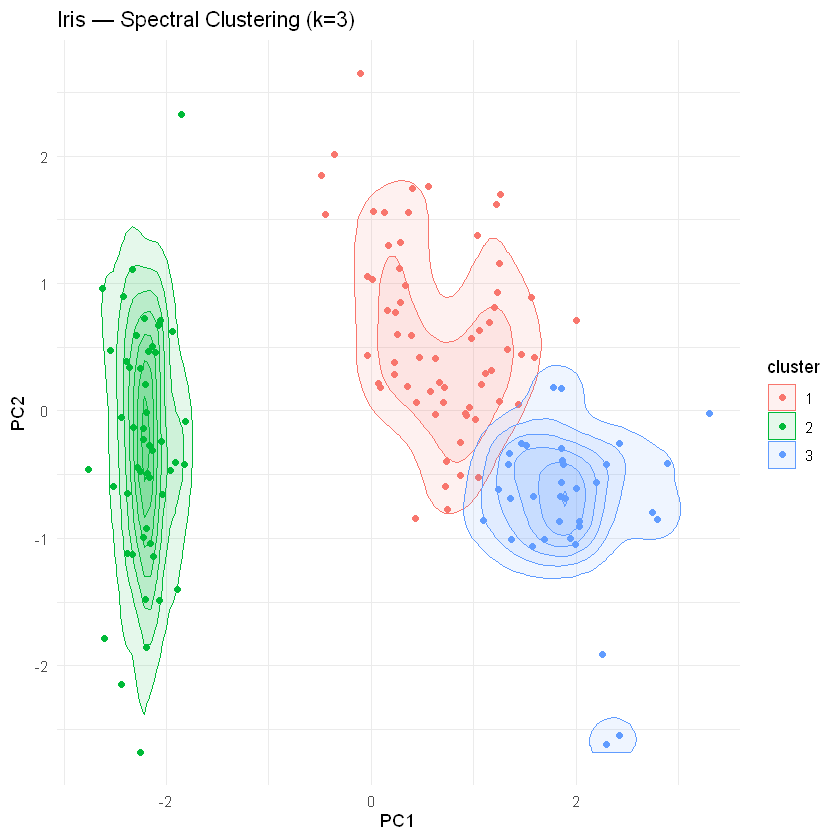

In [46]:
# PCA scatter plot
pca_iris_spectral <- pca_iris_df
pca_iris_spectral$cluster <- as.factor(iris_clusters_spectral)

# PCA scatter plot of spectral clustering results on iris
ggplot(pca_iris_spectral, aes(x = PC1, y = PC2, color = cluster)) +
  geom_point() +
  #stat_ellipse(aes(group = cluster), type = "norm", level = 0.95) +
  stat_density_2d(aes(fill = cluster), geom = "polygon", alpha = 0.1, bins = 8) +
  #geom_mark_hull(aes(fill = cluster), concavity = 2, expand = 0.02, alpha = 0.2) +
  theme_minimal() +
  ggtitle("Iris — Spectral Clustering (k=3)")

### mtcars Dataset

In [47]:
# Spectral clustering on mtcars with k=4
spec_mtcars <- specc(as.matrix(data_mtcars_z), centers = 4)
mtcars_clusters_spectral <- spec_mtcars@.Data

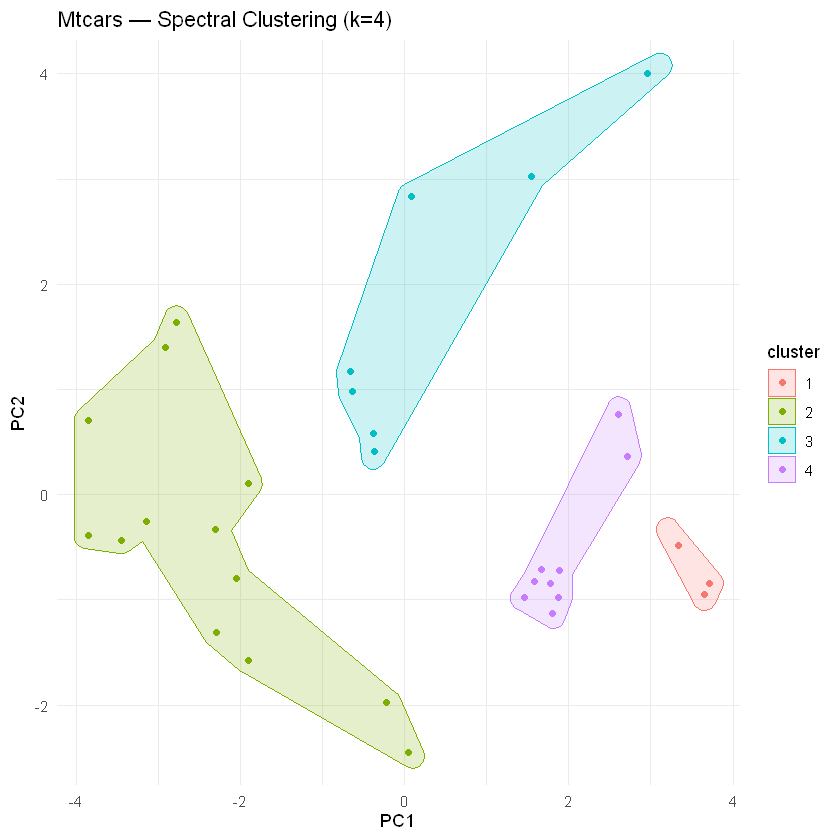

In [48]:
pca_mtcars_spectral <- pca_mtcars_df
pca_mtcars_spectral$cluster <- as.factor(mtcars_clusters_spectral)

# PCA scatter plot of spectral clustering results on mtcars
ggplot(pca_mtcars_spectral, aes(x = PC1, y = PC2, color = cluster)) +
  geom_mark_hull(aes(fill = cluster), concavity = 2, expand = 0.02, alpha = 0.2) +
  geom_point() +
  #stat_ellipse(aes(group = cluster), type = "norm", level = 0.95) +
  theme_minimal() +
  ggtitle("Mtcars — Spectral Clustering (k=4)")

### circles3 Dataset

In [49]:
# Spectral clustering with the true k=3
spec_c3 <- specc(as.matrix(circles3$data), centers = 3)
circles3_clusters_spectral <- spec_c3@.Data

# Confusion matrix
table(circles3$clusters, circles3_clusters_spectral)

   circles3_clusters_spectral
      1   2   3
  1 250   0   0
  2   0   0 250
  3   0 250   0

In [50]:
cat("Accuracy: ", calculate_accuracy(circles3$clusters, circles3_clusters_spectral))

Accuracy:  1

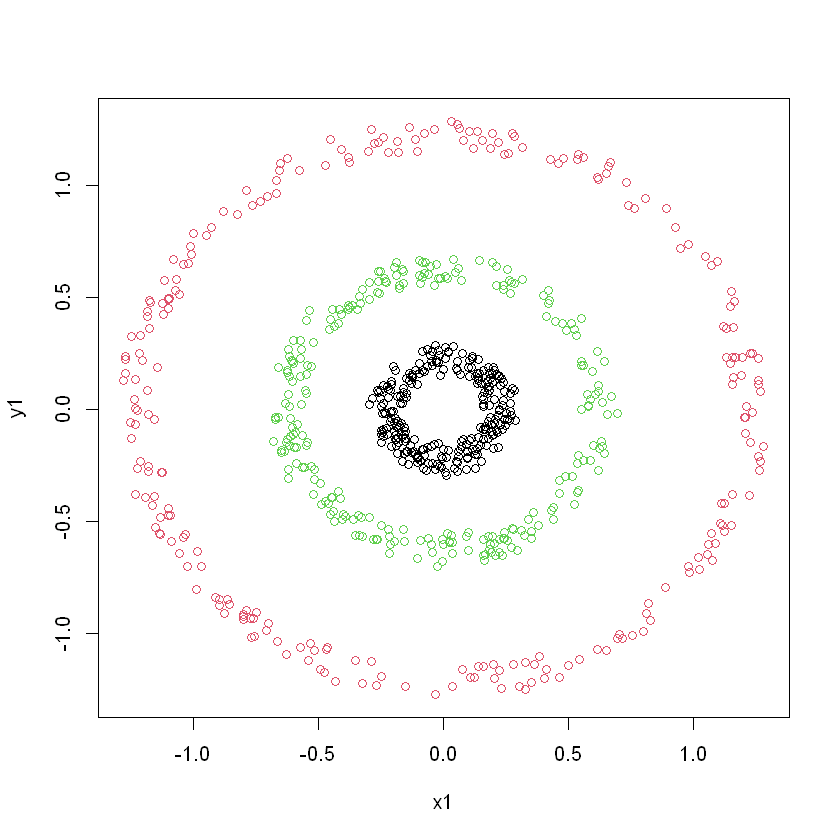

In [51]:
plot(circles3$data, col = circles3_clusters_spectral)

## Summary

| Dataset | K-Means | Hierarchical | Spectral |
|---------|---------|-------------|----------|
| **Iris** | 0.83 | 0.85 | 0.86 |
| **Mtcars** | good* | good* | good* |
| **Circles3** | 0.53 | 0.59 | 1 |

**All algorithms create a slightly different clusters, but they all seem to be reasonable. However, based on the PCA visualizations it seems that more clusters are needed.*

**Results description:** Spectral method performed the best, which makes sense considering its manipulations of dimensions. Hierarchical and K-Means performed similarly. No algorithm was able to distinguish iris versicolor from iris virginica where they overlap, which suggests that a different approach is needed for this problem. Only the spectral method was able to truly encompass the nature of the circles3 dataset.

**Key takeaways:** The data should first be processed, removing differences in magnitudes and ranges of the feature values. It is important to understand the structure of the data, to pick an appropriate algorithm. Algorithms contain hyperparameters, for which optimization is crucial.